In [40]:
# --- Load libraries ---
import pandas as pd
import glob
import os
import re
from collections import defaultdict
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import textwrap

## Project Background: MSU Library Homepage A/B/n Test

The Montana State University Library conducted an A/B/n test (April 3–10, 2013) to improve homepage engagement.  
User behavior showed imbalance: most visitors clicked **Find (35%)**, some **Request (6%)**, but very few **Interact (2%)**.  

Since *Interact* included valuable links—such as **Reference Services**, the **Writing Center**, and **Library FAQs**—low interaction suggested that the label was unclear or uninviting.  
To address this, four alternative labels were tested: *Connect*, *Learn*, *Help*, and *Services*.

---

## Step 1: Research Design

**Project Goal:**  
Identify which homepage label drives the highest user engagement on the Montana State University Library website.

**Variants:**  
- **Control:** Interact (original label)  
- **Treatments:** Connect, Learn, Help, Services  

**Metrics:**  
- **Click-Through Rate (CTR):** % of visitors who click the category.  
- **Depth of Reach (DoR):** average number of subsequent interactions after the first click.

**Hypotheses:**  
- **H₀:** No significant difference in CTR or DoR between the control and treatment labels.  
- **H₁:** At least one treatment label improves CTR or DoR compared to the control.

**Experimental Design:**  
- Randomly assign homepage visitors to one variant.  
- Keep all other page elements constant.  
- CTR captures initial engagement, DoR captures continued exploration.

**Analysis Overview:**  
1. Extract and transform CrazyEgg and Google Analytics data.  
2. Check daily pageviews for anomalies or volatility.  
3. Test differences in CTR (Chi-squared and pairwise z-tests).  
4. Test differences in DoR using appropriate statistical tests.  
5. Compare results visually to highlight the most engaging variant.
---
## Step 2: Extract & Transform

The raw dataset includes two main data sources:

- **CrazyEgg folder** — contains click-tracking CSV files for each homepage variant.  
  Each subfolder (e.g., *Homepage Version 1 - Interact, 5-29-2013*) includes files such as:  
  `Element List Homepage Version 1 - Interact, 5-29-2013.csv`.  
  These files record the number of user clicks on specific page elements for each label version.

- **GoogleAnalytics folder** — contains a single Excel file:  
  `MSU-Library-Pages-20130529-20130618.xlsx`  
  with two sheets:  
  - **Dataset1:** detailed page-level engagement metrics.  
  - **Dataset2:** daily pageviews across the test period (used to check traffic volatility).

From these raw files, we create two analysis-ready tables:

| Table | Source | Purpose |
|-------|---------|----------|
| **CTR Table** | CrazyEgg CSV files | Calculate total clicks and CTR per variant (measure of initial engagement). |
| **DoR Table** | CrazyEgg + GoogleAnalytics Dataset1 | Measure user depth of engagement after first click. |
| **Traffic Stability Table** | GoogleAnalytics Dataset2 | Check if daily pageviews fluctuate abnormally, which might bias test results. |

**Data Extraction Plan:**
1. Automatically loop through CrazyEgg folders to read and combine all CSVs.  
2. Summarize clicks by variant to form the CTR table.  
3. Merge with Google Analytics Dataset1 to compute DoR table.  
4. Use Dataset2 to calculate metrics like `pct_change`, `z_score`, and visualize daily volatility.

These transformed tables serve as the foundation for the statistical testing phase.

### Build CTR Table

From the CrazyEgg dataset, each homepage variant folder contains multiple CSV files recording element clicks and total visits.  
Here, I extract and aggregate these files to calculate total clicks and pageviews per variant.  
The resulting CTR table summarizes **user engagement across test groups**, serving as the input for subsequent **Chi-Square and z-tests** to compare control vs. treatments.

In [41]:
# Path to the dataset folder
base_path = "dataset/CrazyEgg"
all_files = glob.glob(os.path.join(base_path, "Homepage Version*/*.csv"))

# List of target variants (to keep consistent order)
target_variants = ["INTERACT", "CONNECT", "LEARN", "HELP", "SERVICES"]

# Create accumulator for each variant
acc = defaultdict(lambda: {"cat_clicks": 0, "tot_page_visits": None})

# Iterate through each CSV file
for file in all_files:
    filename = os.path.basename(file)
    
    # Read CSV file (try UTF-8, fallback to Latin-1)
    try:
        df_raw = pd.read_csv(file, encoding="utf-8")
    except Exception:
        df_raw = pd.read_csv(file, encoding="latin1")
    
    # Extract total page visits (tot_page_visits)
    snapshot_col = next((c for c in df_raw.columns if "snapshot" in c.lower()), None)
    tot_page_visits = None
    
    if snapshot_col:
        sample_vals = df_raw[snapshot_col].dropna().astype(str)
        if not sample_vals.empty:
            sample = sample_vals.iloc[0]
            m = re.search(r"([\d,]+)\s+visits", sample, flags=re.I)
            if m:
                tot_page_visits = int(m.group(1).replace(",", ""))
    
    # Fallback: if not found yet, search the entire file text
    if tot_page_visits is None:
        with open(file, "r", encoding="utf-8", errors="ignore") as f:
            raw = f.read()
        m = re.search(r"([\d,]+)\s+visits", raw, flags=re.I)
        if m:
            tot_page_visits = int(m.group(1).replace(",", ""))
    
    # Standardize column names
    df_raw.columns = (
        df_raw.columns.str.strip()
                      .str.lower()
                      .str.replace(r"[^\w]+", "_", regex=True)
                      .str.strip("_")
    )
    
    # Skip if no "name" column exists
    if "name" not in df_raw.columns:
        continue
    
    # Handle "no_clicks" column
    if "no_clicks" in df_raw.columns:
        df_raw["no_clicks"] = pd.to_numeric(df_raw["no_clicks"], errors="coerce").fillna(0).astype(int)
    else:
        df_raw["no_clicks"] = 0
    
    # Normalize the "name" column
    df_raw["name_norm"] = df_raw["name"].astype(str).str.upper().str.replace(r"[^\w]", "", regex=True)
    
    # Extract variant name from file or folder
    m_var = re.search(r"Version\s*\d+\s*-\s*([A-Za-z]+)", filename, flags=re.I)
    if not m_var:
        folder = os.path.basename(os.path.dirname(file))
        m_var = re.search(r"-\s*([A-Za-z]+)", folder)
    
    variant = m_var.group(1).upper() if m_var else None
    if variant is None or variant not in target_variants:
        continue
    
    variant_norm = re.sub(r"[^\w]", "", variant.upper())
    
    # Filter rows where "name" matches variant
    matched = df_raw[df_raw["name_norm"] == variant_norm]
    cat_clicks = int(matched["no_clicks"].sum())
    
    # Accumulate results
    acc[variant]["cat_clicks"] += cat_clicks
    if tot_page_visits is not None:
        if acc[variant]["tot_page_visits"] is None:
            acc[variant]["tot_page_visits"] = tot_page_visits
        else:
            acc[variant]["tot_page_visits"] = max(acc[variant]["tot_page_visits"], tot_page_visits)

# Create the final summary DataFrame
rows = []
for v in target_variants:
    data = acc.get(v, {"cat_clicks": 0, "tot_page_visits": None})
    tot = data["tot_page_visits"]
    clicks = data["cat_clicks"]
    ctr = clicks / tot if (tot and tot > 0) else None
    rows.append({
        "test_group": v.lower(),
        "cat_clicks": clicks,
        "tot_page_visits": tot,
        "ctr": ctr
    })

ctr_summary = pd.DataFrame(rows)

# Display result as a formatted table
pd.set_option("display.float_format", "{:.6f}".format)
display(ctr_summary)

,test_group,cat_clicks,tot_page_visits,ctr
0,interact,42,10283,0.004084
1,connect,53,2742,0.019329
2,learn,21,2747,0.007645
3,help,38,3180,0.011950
4,services,45,2064,0.021802


### Build DoR Table

Use **Google Analytics – Dataset1** to measure how deeply users explore the site after the first click.  
Each homepage version is identified by its unique URL, then mapped to the corresponding test group.  
From pageviews and drop-off rates, I calculate the number of **exits** and **non-exits** per variant.  
The resulting DoR table captures **post-click engagement**, which will be compared across control and treatment groups in the next statistical tests.

In [42]:
# Load the Excel file
file_path = "dataset/GoogleAnalytics/MSU-Library-Pages-20130529-20130618.xlsx"

# Read the "Dataset1" sheet
df = pd.read_excel(file_path, sheet_name="Dataset1")

# Standardize column names
df.columns = (
    df.columns.str.strip()
               .str.lower()
               .str.replace(r"[^\w]+", "_", regex=True)
               .str.strip("_")
)

# URL to test group mapping
url_map = {
    "/": "Interact", 
    "/index2.php": "Connect",
    "/index3.php": "Learn",
    "/index4.php": "Help",
    "/index5.php": "Services"
}

# Filter only relevant rows
df_filtered = df[df["page"].isin(url_map.keys())].copy()

# Assign test group labels
df_filtered["test_group"] = df_filtered["page"].map(url_map)

# Convert columns to numeric and compute metrics
df_filtered["dropoff_rate"] = pd.to_numeric(df_filtered["exit"], errors="coerce")
df_filtered["pageviews"] = pd.to_numeric(df_filtered["pageviews"], errors="coerce")

# Calculate exits and non-exits
df_filtered["exits"] = (df_filtered["pageviews"] * df_filtered["dropoff_rate"]).round().astype(int)
df_filtered["non_exits"] = df_filtered["pageviews"] - df_filtered["exits"]

# Create dor summary table
dor_summary = (
    df_filtered[["test_group", "dropoff_rate", "pageviews", "exits", "non_exits"]]
    .reset_index(drop=True)
)

# (Optional) Match row order with ctr_summary if available
if "ctr_summary" in locals():
    order = ctr_summary["test_group"].str.capitalize().tolist()
    dor_summary["test_group"] = pd.Categorical(
        dor_summary["test_group"], 
        categories=order, 
        ordered=True
    )

# Sort test groups by lowest to highest dropoff_rate
dor_summary = dor_summary.sort_values(by="dropoff_rate", ascending=True).reset_index(drop=True)

# Display formatted table
pd.set_option("display.float_format", "{:.3f}".format)
display(dor_summary)

c:\Users\Admin\miniconda3\envs\abtest\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,test_group,dropoff_rate,pageviews,exits,non_exits
0,Interact,0.388,2206,857,1349
1,Connect,0.414,2099,869,1230
2,Learn,0.431,2213,953,1260
3,Services,0.447,2284,1021,1263
4,Help,0.450,2210,994,1216


### Prepare Daily Pageviews Table

Load **Google Analytics – Dataset2** to examine daily traffic trends during the test period.  
Convert date values, clean potential total rows, and sort chronologically.  
This table will be used to check for **anomalies or volatility in pageviews**, ensuring the A/B/n test data was collected under stable conditions.

In [43]:
# Read sheet "Dataset2"
daily_pages = pd.read_excel(file_path, sheet_name="Dataset2")

# --- Preprocess data ---
# Convert 'Day Index' to datetime
daily_pages['Day Index'] = pd.to_datetime(daily_pages['Day Index'], errors='coerce')

# Drop the last row if it's the total (assume NaT or extreme value)
daily_pages = daily_pages.dropna(subset=['Day Index']).reset_index(drop=True)

# Sort by date
daily_pages = daily_pages.sort_values('Day Index')

c:\Users\Admin\miniconda3\envs\abtest\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


---
## Step 3: Check Data Stability — Daily Pageviews Analysis

Before running the A/B/n test, I examined whether pageviews during the data collection period were stable.  
If traffic fluctuates sharply between days, it could bias user exposure across variants and weaken the reliability of test results.

### Visualize Daily Pageviews

First, I plotted daily pageviews from **Google Analytics – Dataset2** to check for any visible spikes or drops in traffic.

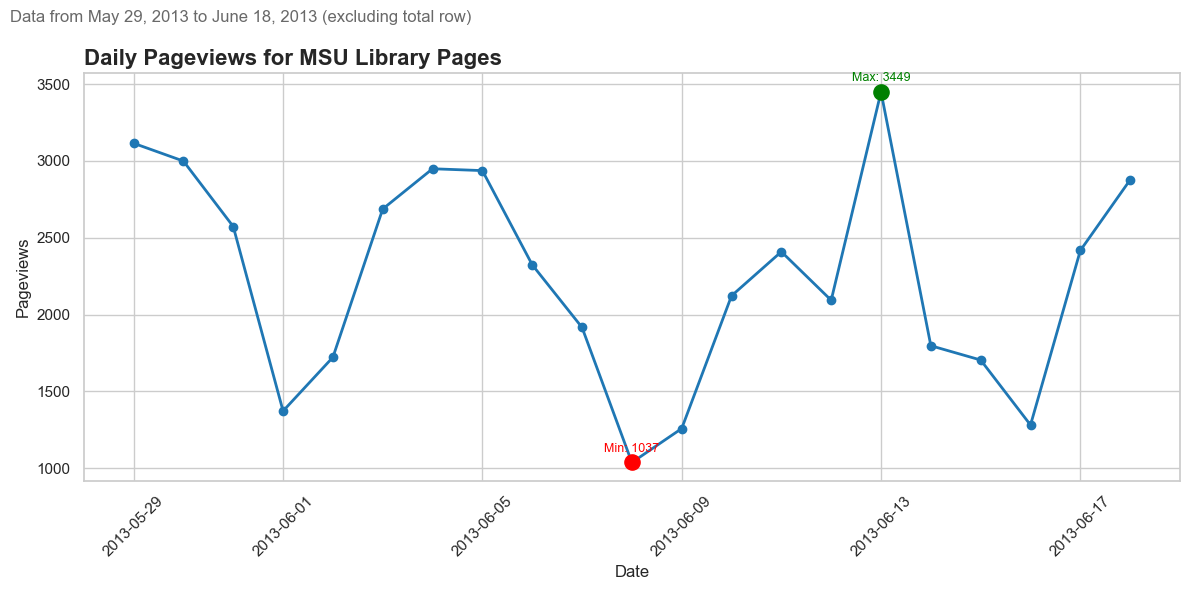

In [44]:
# --- Visualization setup ---
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12,6))

# Plot line chart with markers
plt.plot(daily_pages['Day Index'], daily_pages['Pageviews'], marker='o', linewidth=2, color="#1f77b4")

# Highlight the day with max and min pageviews
max_row = daily_pages.loc[daily_pages['Pageviews'].idxmax()]
min_row = daily_pages.loc[daily_pages['Pageviews'].idxmin()]
plt.scatter(max_row['Day Index'], max_row['Pageviews'], color='green', s=120, zorder=5)
plt.scatter(min_row['Day Index'], min_row['Pageviews'], color='red', s=120, zorder=5)

# Add data labels for max/min points
plt.text(max_row['Day Index'], max_row['Pageviews'] + 50, f"Max: {max_row['Pageviews']}", 
         ha='center', va='bottom', fontsize=9, color='green')
plt.text(min_row['Day Index'], min_row['Pageviews'] + 50, f"Min: {min_row['Pageviews']}", 
         ha='center', va='bottom', fontsize=9, color='red')

# Add titles and labels
plt.title("Daily Pageviews for MSU Library Pages", fontsize=16, weight='bold', loc='left')
plt.suptitle("Data from May 29, 2013 to June 18, 2013 (excluding total row)", fontsize=12, color="dimgray", x=0.01, ha='left')

plt.xlabel("Date", fontsize=12)
plt.ylabel("Pageviews", fontsize=12)

# Improve x-axis date formatting
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The line chart shows continuous fluctuations in daily traffic, ranging roughly from **1,000 to 3,500 pageviews**.  
This variation suggests potential instability, so I performed a simple volatility check to quantify the changes.

---

### Quantify Volatility and Identify Unusual Days

To assess whether traffic changes might affect test validity, I calculated:  
- **pct_change:** day-to-day percentage change in pageviews.  
- **z_score:** deviation of each day’s pageviews from the overall mean.  
- **volatility ratio (std/mean):** overall traffic variability level.

Days with >50% change or |z| > 3 were flagged as unusually volatile.

In [45]:
# --- Preprocess data ---
daily_pages = pd.read_excel(file_path, sheet_name="Dataset2")
daily_pages['Day Index'] = pd.to_datetime(daily_pages['Day Index'], errors='coerce')
daily_pages = daily_pages.dropna(subset=['Day Index']).reset_index(drop=True)
daily_pages = daily_pages.sort_values('Day Index')

# --- Calculate daily percent change ---
daily_pages['pct_change'] = daily_pages['Pageviews'].pct_change() * 100

# --- Calculate z-score for pageviews ---
daily_pages['z_score'] = (daily_pages['Pageviews'] - daily_pages['Pageviews'].mean()) / daily_pages['Pageviews'].std()

# --- Identify unusual changes ---
threshold_pct = 50   # more than 50% change considered unusual
threshold_z = 3      # z-score beyond 3 considered extreme

unusual_days = daily_pages[(daily_pages['pct_change'].abs() > threshold_pct) | (daily_pages['z_score'].abs() > threshold_z)]

print("Unusually volatile days that might affect AB/n test:")
print(unusual_days[['Day Index', 'Pageviews', 'pct_change', 'z_score']])

# --- Check overall volatility ---
std_pageviews = daily_pages['Pageviews'].std()
mean_pageviews = daily_pages['Pageviews'].mean()
volatility_ratio = std_pageviews / mean_pageviews

print(f"\nMean pageviews: {mean_pageviews:.2f}, Std: {std_pageviews:.2f}, Volatility ratio (std/mean): {volatility_ratio:.2f}")

Unusually volatile days that might affect AB/n test:
    Day Index  Pageviews  pct_change  z_score
5  2013-06-03       2687      56.039    0.647
12 2013-06-10       2122      68.680   -0.171
15 2013-06-13       3449      64.787    1.750
19 2013-06-17       2417      88.681    0.256

Mean pageviews: 2239.90, Std: 691.10, Volatility ratio (std/mean): 0.31


c:\Users\Admin\miniconda3\envs\abtest\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Although the line chart shows noticeable daily swings, the statistical check suggests that these fluctuations are within a tolerable range:

- The **z-scores** of all days remain well within ±3, indicating no extreme outliers relative to the mean.  
- The **volatility ratio (0.31)** reflects some day-to-day variation but not unusually high for real-world web traffic.  
- The observed changes appear gradual across consecutive days rather than sharp one-day spikes, suggesting typical user activity rather than data quality issues.  

Therefore, while daily pageviews fluctuated between **~1,000 and ~3,500**, this variation likely represents **natural usage patterns**, not anomalies.  
Hence, the dataset remains **reliable enough for the A/B/n test**, though results should still be interpreted with awareness of moderate volatility.

---

## Step 4 — Analyze: Statistical Testing and CTR Performance Evaluation

After confirming that daily traffic volatility was within a normal range, I proceeded to test whether the observed differences in CTR across variants were statistically significant.

### Overall Difference Test — Chi-Square Test of Independence
> **H₀:** There is **no difference** in CTR distributions across all groups — i.e., click behavior is independent of test variant.

> **H₁:** There **is a difference** in CTR distributions — i.e., click behavior depends on the test variant.

I applied the **Chi-square test of independence** to check if the overall distribution of clicks vs. non-clicks differs among the groups.

In [46]:
# Make a copy to avoid modifying the original DataFrame
df = ctr_summary.copy()

# Standardize column names for clarity
df = df.rename(columns={
    "cat_clicks": "clicks",
    "tot_page_visits": "tot_page_visits"
})

# Drop invalid rows (missing total visits or clicks)
df = df.dropna(subset=["clicks", "tot_page_visits"])

# Calculate non-clicks by subtracting clicks from total page visits
df["non_clicks"] = df["tot_page_visits"] - df["clicks"]

# Create a contingency table (matrix) for clicks vs non-clicks
contingency = df[["clicks", "non_clicks"]].to_numpy()

# Perform the Chi-squared test of independence
chi2, p, dof, expected = chi2_contingency(contingency)

# Print the Chi-squared statistic and p-value
print(f"Chi-squared = {chi2:.3f}, p-value = {p:.5f}")

Chi-squared = 96.743, p-value = 0.00000


Because the p-value is far below the 0.05 threshold, we **reject H₀**.  
This means **at least one variant differs significantly** in CTR compared to others — a strong reason to proceed with pairwise comparisons.

---

### Pairwise Comparison — Z-Test for Proportions

After confirming that differences exist globally, the next step is to pinpoint **which variants** differ from the control.

#### Statistical Hypotheses (for each pair)
> **H₀:** CTR_variant = CTR_control (no difference in proportions)  
> **H₁:** CTR_variant ≠ CTR_control (CTR differs between groups)

Since I conducted four pairwise comparisons, I used the **Bonferroni correction** to control for multiple testing:
> Adjusted significance level: α = 0.05 / 4 = **0.0125**

In [47]:
# Select the control group (interact)
control = df[df["test_group"] == "interact"].iloc[0]

# Select all other groups as treatment groups
treatments = df[df["test_group"] != "interact"]

# Apply Bonferroni correction for multiple comparisons
alpha_adj = 0.05 / len(treatments)

print("=== Pairwise Comparison (Z-test for proportions) ===")
print(f"Adjusted significance level (Bonferroni): {alpha_adj:.4f}\n")

# Compare each treatment group against the control group
for _, row in treatments.iterrows():
    stat, pval = proportions_ztest(
        [row["clicks"], control["clicks"]],
        [row["tot_page_visits"], control["tot_page_visits"]],
        alternative='two-sided'
    )
    
    # Determine if statistically significant
    sig = "Yes" if pval < alpha_adj else "No"
    direction = "higher" if (row["clicks"]/row["tot_page_visits"]) > (control["clicks"]/control["tot_page_visits"]) else "lower"
    
    # Print the result for each comparison
    print(f"{row['test_group']} vs interact → p = {pval:.5f}, "
          f"CTR is {direction} than control → Statistically significant? {sig}")

=== Pairwise Comparison (Z-test for proportions) ===
Adjusted significance level (Bonferroni): 0.0125

connect vs interact → p = 0.00000, CTR is higher than control → Statistically significant? Yes
learn vs interact → p = 0.01686, CTR is higher than control → Statistically significant? No
help vs interact → p = 0.00000, CTR is higher than control → Statistically significant? Yes
services vs interact → p = 0.00000, CTR is higher than control → Statistically significant? Yes


### Visualization of CTR and Confidence Intervals
To make the results more interpretable, I visualized each variant’s CTR along with **95% confidence intervals**.  
This chart allows a quick comparison of both magnitude and uncertainty.

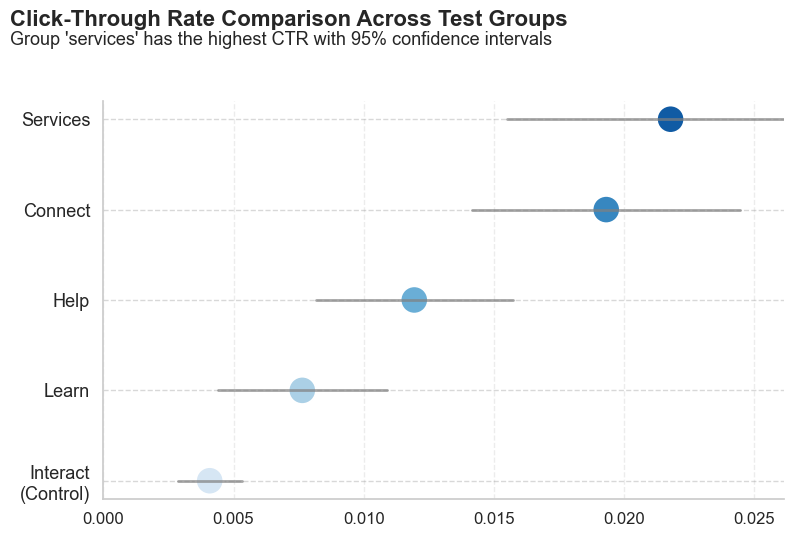

In [48]:
sns.set_theme(style="whitegrid")  # baseline style

# Copy and preprocess data
ctr_sorted = ctr_summary.copy()
ctr_sorted.loc[ctr_sorted["test_group"]=="interact", "test_group"] = "interact (control)"
ctr_sorted = ctr_sorted.sort_values("ctr", ascending=False).reset_index(drop=True)

# Calculate 95% confidence intervals for CTR
ctr_sorted["ci_lower"] = ctr_sorted["ctr"] - 1.96 * np.sqrt(ctr_sorted["ctr"]*(1-ctr_sorted["ctr"])/ctr_sorted["tot_page_visits"])
ctr_sorted["ci_upper"] = ctr_sorted["ctr"] + 1.96 * np.sqrt(ctr_sorted["ctr"]*(1-ctr_sorted["ctr"])/ctr_sorted["tot_page_visits"])

# Generate a gradient color palette
colors = sns.color_palette("Blues", len(ctr_sorted))[::-1]

# Wrap y-axis labels if too long and convert to title case
wrapped_labels = [textwrap.fill(label.title(), width=15) for label in ctr_sorted['test_group']]

# Create figure and axis
fig, ax = plt.subplots(figsize=(8,5))

# Plot the CTR dots
sns.scatterplot(
    x="ctr",
    y="test_group",
    hue="test_group",
    data=ctr_sorted,
    palette=colors,
    s=400,        # larger dots
    legend=False,
    ax=ax
)

# Draw horizontal error bars
for idx, row in ctr_sorted.iterrows():
    ax.plot(
        [row["ci_lower"], row["ci_upper"]],
        [idx, idx],
        color='gray',
        lw=2,
        alpha=0.7
    )

# Enable subtle grid lines
ax.grid(axis='y', color='gray', linestyle='--', alpha=0.3)  # horizontal
ax.grid(axis='x', color='gray', linestyle='--', alpha=0.15) # vertical

# Add figure title and subtitle
fig.suptitle(
    "Click-Through Rate Comparison Across Test Groups",
    fontsize=16,
    weight='bold',
    x=0.01,
    ha='left',
    y=1.07
)
fig.text(
    0.01, 1.0,
    "Group 'services' has the highest CTR with 95% confidence intervals",
    ha='left',
    fontsize=13
)

# Remove axis labels
ax.set_xlabel("")
ax.set_ylabel("")

# Update y-axis tick labels: same font size as subtitle (13pt)
ax.set_yticks(range(len(wrapped_labels)))
ax.set_yticklabels(wrapped_labels, fontsize=13)

# Increase x-axis tick label size
ax.tick_params(axis='x', which='major', labelsize=12)

# Remove top and right spines
sns.despine(ax=ax)

# Set x-axis limits with padding on the right
ax.set_xlim(0, ctr_sorted['ctr'].max()*1.2)

# Adjust layout
plt.tight_layout()
plt.show()

- The **Chi-square test** confirms that user click behavior **differs by variant**.  
- The **Z-tests** identify **three significantly higher-performing variants** (Connect, Help, Services).  
- The **Services** variant not only performs best numerically but also maintains a tight confidence interval, suggesting a stable improvement.

Overall, the statistical evidence supports that the experiment’s design successfully created meaningful behavioral differences — especially for the **Services** and **Help** variants. These can be prioritized for further UX validation or rolled out in production.

---

## Step 5 — Analyze: Statistical Significance of Drop-off Rate (DoR) Differences

After evaluating user engagement through CTR, I examined the **Drop-off Rate (DoR)** to understand how many users left the site after visiting each variant.  
Because a **lower DoR** indicates better retention, this metric complements CTR by showing whether increased clicks come at the cost of higher exits.  
The *Interact* group acts as the **control**, while *Connect*, *Learn*, *Help*, and *Services* are **treatments**.

### Overall Difference Test — Chi-Square Test of Independence
> **H₀ (Null Hypothesis):** Drop-off behavior is **independent** of the test variant (no difference in DoR among groups).  
> **H₁ (Alternative Hypothesis):** Drop-off behavior **depends** on the test variant (at least one group differs).

The **Chi-square test** checks if the overall distribution of exits and non-exits differs across all groups.

In [49]:
# Copy the summary to a new DataFrame for testing
df = dor_summary.copy()

# Ensure columns are properly named and numeric
df["exits"] = pd.to_numeric(df["exits"], errors="coerce")
df["non_exits"] = pd.to_numeric(df["non_exits"], errors="coerce")

# Drop any invalid rows (missing exits or non_exits)
df = df.dropna(subset=["exits", "non_exits"])

# Create contingency table (exits vs non-exits across test groups)
contingency = df[["exits", "non_exits"]].to_numpy()

# Perform the Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency)

# Print the Chi-squared statistic and p-value
print(f"Chi-squared = {chi2:.3f}, p-value = {p:.5f}")

Chi-squared = 23.355, p-value = 0.00011


Because the p-value < 0.05, we **reject H₀**, meaning there is a statistically significant difference in drop-off behavior between at least some variants and the control.  
This indicates that variant design might be influencing users’ tendency to leave the page.

---

### Pairwise Comparison — Z-Test for Proportions

After confirming overall significance, I performed **pairwise proportion Z-tests** between each variant and the control to identify where differences occur.

#### Statistical Hypotheses (for each pair)
> **H₀:** DoR_variant = DoR_control (no difference in exit proportions)  
> **H₁:** DoR_variant ≠ DoR_control (difference in exit proportions)

To control for multiple comparisons, I again used the **Bonferroni correction**:
> Adjusted significance level: α = 0.05 / 4 = **0.0125**

In [50]:
# Select the control group (Interact)
control = df[df["test_group"] == "Interact"].iloc[0]

# Select all other groups as treatment groups
treatments = df[df["test_group"] != "Interact"]

# Apply Bonferroni correction for multiple comparisons
alpha_adj = 0.05 / len(treatments)  # Adjusted significance level

print("=== Pairwise Comparison (Z-test for proportions) ===")
print(f"Adjusted significance level (Bonferroni): {alpha_adj:.4f}\n")

# Compare each treatment group against the control group using Z-test for proportions
for _, row in treatments.iterrows():
    stat, pval = proportions_ztest(
        [row["exits"], control["exits"]],
        [row["pageviews"], control["pageviews"]],
        alternative='two-sided'
    )
    
    # Determine if statistically significant
    sig = "Yes" if pval < alpha_adj else "No"
    direction = "higher" if row["dropoff_rate"] > control["dropoff_rate"] else "lower"
    
    # Print the result for each comparison
    print(f"{row['test_group']} vs Interact → p = {pval:.5f}, "
          f"Drop-off is {direction} than control → Statistically significant? {sig}")

=== Pairwise Comparison (Z-test for proportions) ===
Adjusted significance level (Bonferroni): 0.0125

Connect vs Interact → p = 0.08767, Drop-off is higher than control → Statistically significant? No
Learn vs Interact → p = 0.00439, Drop-off is higher than control → Statistically significant? Yes
Services vs Interact → p = 0.00007, Drop-off is higher than control → Statistically significant? Yes
Help vs Interact → p = 0.00004, Drop-off is higher than control → Statistically significant? Yes


### Visualization — DoR with 95% Confidence Intervals

To visualize retention patterns, I plotted each group’s **mean Drop-off Rate (DoR)** with **95% confidence intervals**.  
The chart helps reveal whether observed differences are both statistically and practically meaningful.

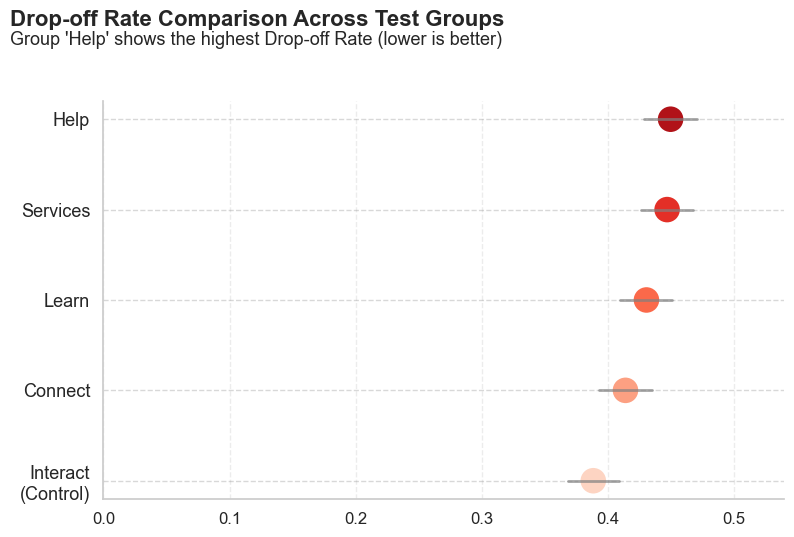

In [51]:
sns.set_theme(style="whitegrid")

# Copy and preprocess data
dor_sorted = dor_summary.copy()

# Mark control group
dor_sorted["test_group"] = dor_sorted["test_group"].astype(str)
dor_sorted.loc[dor_sorted["test_group"].str.lower() == "interact", "test_group"] = "Interact (Control)"

# Sort descending by drop-off rate
dor_sorted = dor_sorted.sort_values("dropoff_rate", ascending=False).reset_index(drop=True)

# --- Compute 95% Confidence Interval for Drop-off Rate ---
dor_sorted["ci_lower"] = dor_sorted["dropoff_rate"] - 1.96 * np.sqrt(
    dor_sorted["dropoff_rate"] * (1 - dor_sorted["dropoff_rate"]) / dor_sorted["pageviews"]
)
dor_sorted["ci_upper"] = dor_sorted["dropoff_rate"] + 1.96 * np.sqrt(
    dor_sorted["dropoff_rate"] * (1 - dor_sorted["dropoff_rate"]) / dor_sorted["pageviews"]
)

# --- Visualization ---
colors = sns.color_palette("Reds", len(dor_sorted))[::-1]  # red tones for drop-off
wrapped_labels = [textwrap.fill(label.title(), width=15) for label in dor_sorted["test_group"]]

fig, ax = plt.subplots(figsize=(8, 5))

# Draw dots
sns.scatterplot(
    x="dropoff_rate",
    y="test_group",
    hue="test_group",
    data=dor_sorted,
    palette=colors,
    s=400,
    legend=False,
    ax=ax
)

# Draw confidence intervals as horizontal error bars
for idx, row in dor_sorted.iterrows():
    ax.plot(
        [row["ci_lower"], row["ci_upper"]],
        [idx, idx],
        color="gray",
        lw=2,
        alpha=0.7
    )

# Grid & styling
ax.grid(axis="y", color="gray", linestyle="--", alpha=0.3)
ax.grid(axis="x", color="gray", linestyle="--", alpha=0.15)

# Titles and annotations
fig.suptitle(
    "Drop-off Rate Comparison Across Test Groups",
    fontsize=16,
    weight="bold",
    x=0.01,
    ha="left",
    y=1.07
)
fig.text(
    0.01, 1.0,
    "Group 'Help' shows the highest Drop-off Rate (lower is better)",
    ha="left",
    fontsize=13
)

# Axis labels and ticks
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_yticks(range(len(wrapped_labels)))
ax.set_yticklabels(wrapped_labels, fontsize=13)
ax.tick_params(axis="x", which="major", labelsize=12)

# Clean up
sns.despine(ax=ax)
ax.set_xlim(0, dor_sorted["dropoff_rate"].max() * 1.2)

plt.tight_layout()
plt.show()

- The **Chi-square test** confirms that exit behavior differs by variant.  
- The **pairwise Z-tests** show that **most treatments have higher drop-offs**, except *Connect*.  
- Combined with CTR results:
  - *Help* and *Services* drive higher CTR but also increase exits — suggesting superficial engagement.
  - *Connect* offers a balanced improvement: higher CTR **without** a significant increase in drop-offs.
  - *Interact (Control)* remains the most stable baseline for user retention.

In summary, while several designs boost clicks, **Connect** achieves the best trade-off between engagement and retention — making it the most promising variant to consider for broader rollout.

---

## Step 6 — Summarize & Recommend

### Synthesis of Findings  
CTR and Drop-off Rate results were combined and visualized to evaluate trade-offs between **user engagement** and **retention stability**.  
Two complementary charts were created:  
- A **quadrant chart** mapping each variant’s position (High/Low CTR vs. High/Low Drop-off).  
- A **trade-off efficiency chart** showing the cost in Drop-off per CTR gain.  

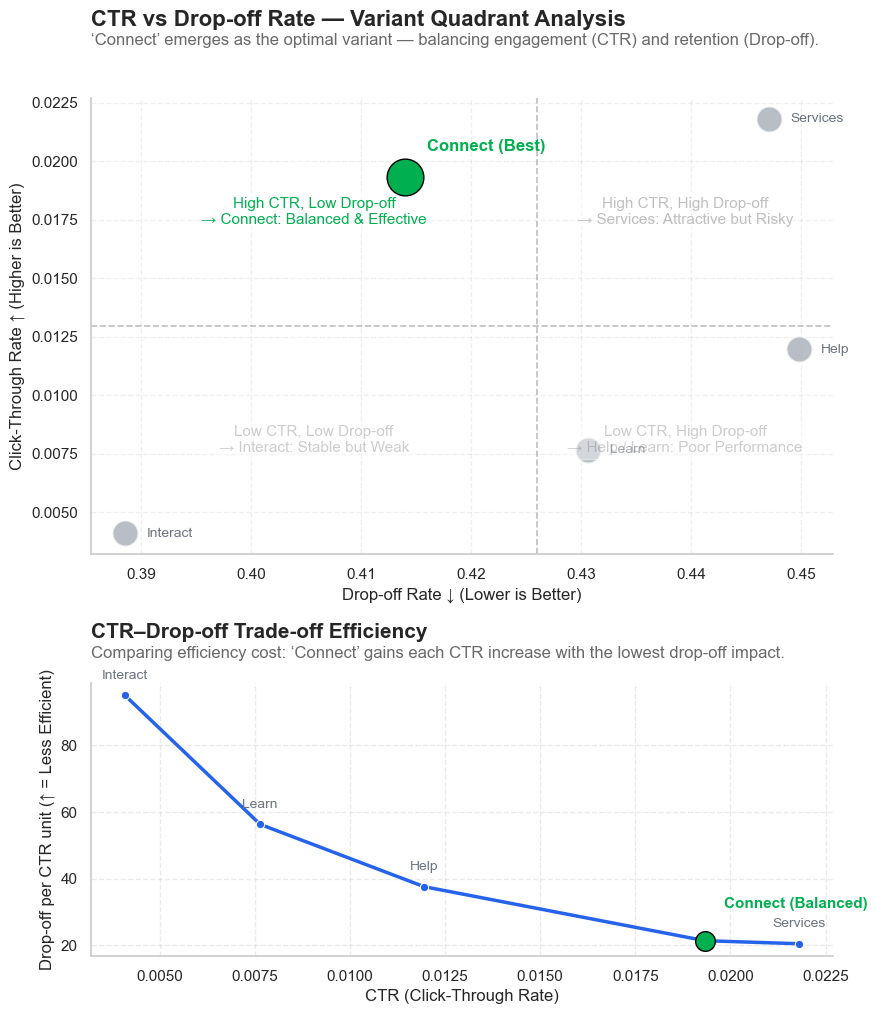

In [52]:
# Standardize names
ctr = ctr_summary.copy()
dor = dor_summary.copy()
ctr["test_group"] = ctr["test_group"].str.lower().str.strip()
dor["test_group"] = dor["test_group"].str.lower().str.strip()

# Merge CTR + Drop-off
merged = ctr.merge(
    dor[["test_group", "dropoff_rate"]],
    on="test_group",
    how="inner"
)

# Calculate quadrant means
mean_ctr = merged["ctr"].mean()
mean_dor = merged["dropoff_rate"].mean()

# --- Visualization Setup ---
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(9, 11), gridspec_kw={"height_ratios": [2, 1.2]})

highlight_color = "#00B050"   # green (Connect)
base_color = "#9ca3af"        # gray-blue

# ==========================================================
# 1️⃣ QUADRANT INSIGHT CHART
# ==========================================================
ax = axes[0]

# Plot all points (gray baseline)
sns.scatterplot(
    data=merged,
    x="dropoff_rate",
    y="ctr",
    color=base_color,
    s=350,
    alpha=0.7,
    ax=ax,
    legend=False
)

# Highlight best variant (Connect)
best_variant = "connect"
best = merged[merged["test_group"] == best_variant].iloc[0]
ax.scatter(best["dropoff_rate"], best["ctr"], s=700, color=highlight_color, edgecolor="black", zorder=5)
ax.text(best["dropoff_rate"] + 0.002, best["ctr"] + 0.001,
        "Connect (Best)", color=highlight_color, weight="bold", fontsize=12, va="bottom")

# Label others
for _, row in merged.iterrows():
    if row["test_group"] != best_variant:
        ax.text(row["dropoff_rate"] + 0.002, row["ctr"],
                row["test_group"].title(), fontsize=10, color="#6b7280", va="center")

# Add quadrant lines
ax.axvline(mean_dor, color="gray", linestyle="--", lw=1.2, alpha=0.5)
ax.axhline(mean_ctr, color="gray", linestyle="--", lw=1.2, alpha=0.5)

# Quadrant annotation
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
x_mid, y_mid = mean_dor, mean_ctr

messages = {
    "top_left":  ("High CTR, Low Drop-off\n→ Connect: Balanced & Effective", 1.0, highlight_color),
    "top_right": ("High CTR, High Drop-off\n→ Services: Attractive but Risky", 0.5, "gray"),
    "bottom_left": ("Low CTR, Low Drop-off\n→ Interact: Stable but Weak", 0.4, "gray"),
    "bottom_right": ("Low CTR, High Drop-off\n→ Help / Learn: Poor Performance", 0.4, "gray"),
}

for pos, (msg, alpha, color) in messages.items():
    x_pos = x_min + (x_mid - x_min)/2 if "left" in pos else x_mid + (x_max - x_mid)/2
    y_pos = y_mid + (y_max - y_mid)/2 if "top" in pos else y_min + (y_mid - y_min)/2
    ax.text(x_pos, y_pos, msg, fontsize=11, ha="center", va="center",
            color=color, alpha=alpha, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.4))

# Title + subtitle (both left-aligned with clear spacing)
ax.text(0.0, 1.15, "CTR vs Drop-off Rate — Variant Quadrant Analysis",
        transform=ax.transAxes, fontsize=16, weight="bold", ha="left", va="bottom")
ax.text(0.0, 1.11,
        "‘Connect’ emerges as the optimal variant — balancing engagement (CTR) and retention (Drop-off).",
        transform=ax.transAxes, fontsize=12, color="dimgray", ha="left", va="bottom")

# Axis labels
ax.set_xlabel("Drop-off Rate ↓ (Lower is Better)", fontsize=12)
ax.set_ylabel("Click-Through Rate ↑ (Higher is Better)", fontsize=12)
sns.despine(ax=ax)
ax.grid(True, linestyle="--", alpha=0.3)

# ==========================================================
# 2️⃣ TRADE-OFF EFFICIENCY CHART
# ==========================================================
ax2 = axes[1]

# Calculate efficiency ratio
merged = merged.sort_values("ctr")
merged["dropoff_per_ctr"] = merged["dropoff_rate"] / merged["ctr"]

# Plot trend line (drop-off cost per CTR)
sns.lineplot(
    data=merged,
    x="ctr",
    y="dropoff_per_ctr",
    marker="o",
    color="#2563eb",
    linewidth=2.5,
    ax=ax2
)

# Highlight Connect
connect_row = merged[merged["test_group"] == "connect"].iloc[0]
ax2.scatter(connect_row["ctr"], connect_row["dropoff_per_ctr"],
            color=highlight_color, s=200, edgecolor="black", zorder=5)
ax2.text(connect_row["ctr"] + 0.0005, connect_row["dropoff_per_ctr"] + 10,
         "Connect (Balanced)", color=highlight_color, weight="bold", fontsize=11)

# Label others
for _, row in merged.iterrows():
    if row["test_group"] != "connect":
        ax2.text(row["ctr"], row["dropoff_per_ctr"] + 5,
                 row["test_group"].title(), fontsize=10, color="#6b7280", ha="center")

# Title + subtitle (aligned to figure left, complementing chart 1)
ax2.text(0.0, 1.15, "CTR–Drop-off Trade-off Efficiency",
         transform=ax2.transAxes, fontsize=15, weight="bold", ha="left", va="bottom")
ax2.text(0.0, 1.08,
         "Comparing efficiency cost: ‘Connect’ gains each CTR increase with the lowest drop-off impact.",
         transform=ax2.transAxes, fontsize=12, color="dimgray", ha="left", va="bottom")

# Axis labels
ax2.set_xlabel("CTR (Click-Through Rate)", fontsize=12)
ax2.set_ylabel("Drop-off per CTR unit (↑ = Less Efficient)", fontsize=12)
sns.despine(ax=ax2)
ax2.grid(True, linestyle="--", alpha=0.4)

# --- Layout Adjustment ---
plt.tight_layout(rect=[0, 0, 1, 0.94])  # reserved space for top spacing
plt.show()

- **Services** achieves the **highest CTR**, but its Drop-off Rate increases sharply, making it a high-risk option.  
- **Connect** delivers **notably higher CTR than control** while keeping Drop-off Rate **within an acceptable range** —  
  indicating a strong balance between attracting and retaining users.  
- **Help** and **Learn** both underperform in engagement and retention.  
- **Interact (Control)** remains stable but lacks growth potential.  

### Recommendation

Given the company’s strategic focus on **increasing engagement (CTR)** rather than minimizing drop-off,  
**Connect** is the most suitable variant for implementation.  
It achieves a **measurable CTR uplift** without a proportionate loss in retention,  
making it the **optimal balance between visibility and user flow efficiency**.